Using CAMB 1.5.4 installed at /Users/marigalla/AstroCosmoComputational/Students/MariaLuisaGallavotti/CAMB/camb


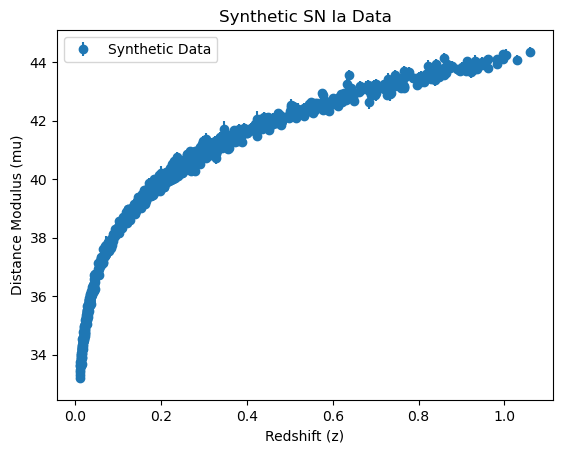

In [7]:
import sys,platform,os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
sys.path.insert(0,_camb_path)

import camb
print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z = data['zcmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Define fiducial cosmology parameters
fiducial_params = {
    'H0': 70.0,
    'Om0': 0.3,
    'w0': -0.55,
    'wa': -0.4
}

# Define the function to compute the distance modulus using CAMB
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Compute theoretical magnitudes using the fiducial cosmology
mu_theoretical = get_mu(z, **fiducial_params)

# Add Gaussian noise to the theoretical magnitudes
np.random.seed(42)  # For reproducibility
dmb = data['dmb'].values
mu_observed = mu_theoretical + np.random.normal(0, dmb)

# Create a new DataFrame with the synthetic data
synthetic_data = data.copy()
synthetic_data['mb'] = mu_observed

# Save synthetic data to a new file
synthetic_data.to_csv('synthetic_lcparam.txt', sep=' ', index=False)

# Plot the synthetic data
plt.errorbar(z, mu_observed, yerr=dmb, fmt='o', label='Synthetic Data')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.title('Synthetic SN Ia Data')
plt.legend()
plt.show()
